In [1]:
DATASET = "celeba"
ROOT_DIR = "/mnt/external/pytorch_datasets/"

Z_DIM = 100

SAMPLE_SIZE = 10

In [2]:
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

if DATASET == "mnist":
    from torchvision.datasets import MNIST
    from torchvision.transforms import Compose, ToTensor, Normalize
    from cpe.mnist import Generator, Encoder
elif DATASET == "celeba":
    from torchvision.datasets import CelebA
    from torchvision.transforms import Compose, Resize, ToTensor, Normalize
    from cpe.celeba import Generator, Encoder
else:
    raise ValueError(f"Dataset {DATASET} is not available.")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
if DATASET == "mnist":
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = MNIST(ROOT_DIR, train=False, transform=transform, download=True)
elif DATASET == "celeba":
    transform = Compose([Resize((64, 64)), ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = CelebA(ROOT_DIR, split="all", transform=transform, download=True)
else:
    raise ValueError(f"Dataset {DATASET} is not available.")

dataloader = DataLoader(dataset, SAMPLE_SIZE, shuffle=True)

Files already downloaded and verified


In [4]:
generator = Generator(Z_DIM).to(device)
generator.load_state_dict(torch.load(f"{DATASET}_generator.pth"))
encoder = Encoder(Z_DIM).to(device)
encoder.load_state_dict(torch.load(f"{DATASET}_encoder.pth"))

<All keys matched successfully>

In [5]:
if DATASET == "mnist":
    imagify = lambda img: img.detach().cpu().numpy().squeeze() / 2 + 0.5
elif DATASET == "celeba":
    imagify = lambda img: img.detach().cpu().numpy().swapaxes(1, 2).swapaxes(2, 3) / 2 + 0.5
else:
    raise ValueError(f"Dataset {DATASET} is not available.")

swap_sign = lambda x, k: x * torch.sign(k)
keygen = lambda: (torch.rand(SAMPLE_SIZE, Z_DIM, 1, 1) * 2 - 1).to(device)

key = keygen()
alt_key = keygen()

plaintext = next(iter(dataloader))[0].to(device)
plaintext_encoding = encoder(plaintext)
ciphertext = generator(swap_sign(plaintext_encoding, key))
alt_ciphertext = generator(swap_sign(plaintext_encoding, alt_key))
ciphertext_encoding = encoder(ciphertext)
restored_plaintext = generator(swap_sign(ciphertext_encoding, key))
wrong_plaintext = generator(swap_sign(ciphertext_encoding, alt_key))

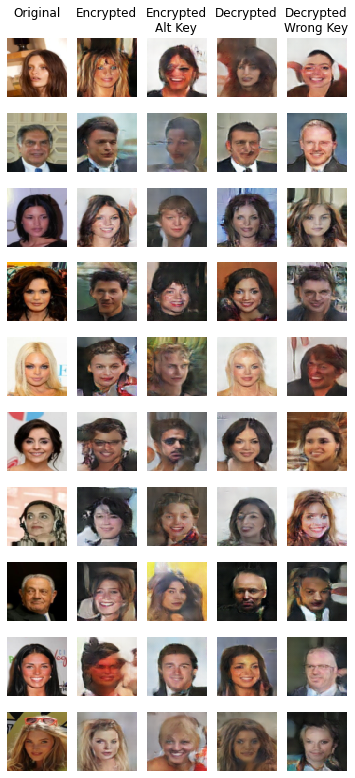

In [6]:
pt_img = imagify(plaintext)
ct_img = imagify(ciphertext)
act_img = imagify(alt_ciphertext)
rpt_img = imagify(restored_plaintext)
wpt_img = imagify(wrong_plaintext)

plt.figure(figsize=(5, SAMPLE_SIZE + 1))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(SAMPLE_SIZE):
    plt.subplot(SAMPLE_SIZE, 5, 5 * i + 1)
    plt.imshow(pt_img[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[0])
    plt.subplot(SAMPLE_SIZE, 5, 5 * i + 2)
    plt.imshow(ct_img[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[1])
    plt.subplot(SAMPLE_SIZE, 5, 5 * i + 3)
    plt.imshow(act_img[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[2])
    plt.subplot(SAMPLE_SIZE, 5, 5 * i + 4)
    plt.imshow(rpt_img[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[3])
    plt.subplot(SAMPLE_SIZE, 5, 5 * i + 5)
    plt.imshow(wpt_img[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[4])
plt.tight_layout()
plt.savefig(f"{DATASET}_results.png", facecolor="w")
plt.show()
